# Simulate circles for multi-segment array

# Import libraries

In [7]:
import os
import sys
import math
import h5py
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from scipy.sparse import save_npz, load_npz 
import time

from scipy.ndimage import affine_transform as affine
from scipy.ndimage import gaussian_filter
from scipy.ndimage import convolve

# custom libraries
if '../reconCPU/oa/MB' not in sys.path:
    sys.path.append('../reconCPU/oa/MB')

# custom libraries
if '../reconCPU/oa/BP' not in sys.path:
    sys.path.append('../reconCPU/oa/BP')

if '../utils' not in sys.path:
    sys.path.append('../utils')

# from modelMatrix import calculateModelMatrix
# from regularization import calculateRegularizationMatrix
# from normalize import sigMatNormalize
# from filterBandPass import sigMatFilter
# from cpuMB import sigMatReconMB
# from cpuBP import sigMatReconBP
# from crop import cropMatrix

# Main

In [2]:
#===== recon parameters =====#

speedOfSound    = 1525
resolutionXY    = 512
reconDimsXY     = 0.0256                      # recon dimensions x and y [m]
fSampling       = 40e6
delayInSamples  = 61                                 # DAQ delay
nSamples        = 2030;                              # number of samples
timePoints      = np.arange(0, (nSamples)/fSampling, 1/fSampling) + delayInSamples/fSampling
nAngles         = 2*resolutionXY
lambdaReg       = 15e6
iterationNum    = 10
lowCutOff       = 0.1e6
highCutOff      = 6e6
fOrder          = 3


# timePoints      = cropMatrix(timePoints, xSensor, ySensor, reconDimsXY, fSampling, speedOfSound, delayInSamples, nSamples)



# Simulate Ellipse and Skin Line

In [3]:
#===== simulation parameters =====#
numImages       = 30

#ellipse limits
rVerticalMin    = 10
rVerticalMax    = 10
rHorizontalMin  = 240
rHorizontalMax  = 300

#circle limits
rCircleMax      = 24;
rCircleMin      = 12;

# create mesh to use in line and ellipse
x               = np.linspace(0,resolutionXY-1,resolutionXY)
y               = np.linspace(0,resolutionXY-1,resolutionXY)
meshX, meshY    = np.meshgrid(x,y)

In [4]:
# loop through the images that you want to create 
imageAll = [];
for indImage in range(0,numImages):
    numEllipses = np.random.randint(6,10)
    numCircles  = np.random.randint(6,10)
    imageVessels = np.zeros((resolutionXY, resolutionXY))


    for indEllipse in range(0,numEllipses):

        # define random ellipse parameters
        rVertEllipse = np.random.uniform(rHorizontalMin, rHorizontalMax)
        rHoriEllipse = np.random.uniform(rVerticalMin, rVerticalMax)

        rotationEllipse     = np.random.uniform(0, 2* math.pi) 

        centerEllipseX      = np.random.randint(resolutionXY)
        centerEllipseY      = np.random.randint(resolutionXY)


        # Draw ellipse 
        cos = np.cos(rotationEllipse)
        sin = np.sin(rotationEllipse)

        meshX_ = meshX - centerEllipseX
        meshY_ = meshY - centerEllipseY

        singleImage = 1 - (((meshX_ * cos + meshY_ * sin) ** 2 ) / (rHoriEllipse**2) + ((meshX_ * sin - meshY_ * cos)**2) / (rVertEllipse**2))

        singleImage[singleImage < 0] = 0


        imageVessels       += singleImage
        
    for indEllipse in range(0,numCircles):

        # define random cirlce parameters
        rVertCircle = np.random.uniform(rCircleMin, rCircleMax)
        rHoriCircle = np.random.uniform(rCircleMin, rCircleMax)

        rotationCircle     = np.random.uniform(0, 2* math.pi) 

        centerCircleX      = np.random.randint(resolutionXY)
        centerCircleY      = np.random.randint(resolutionXY)


        # Draw circle 
        cos = np.cos(rotationCircle)
        sin = np.sin(rotationCircle)

        meshX_ = meshX - centerCircleX
        meshY_ = meshY - centerCircleY

        singleImage = 1 - (((meshX_ * cos + meshY_ * sin) ** 2 ) / (rHoriCircle**2) + ((meshX_ * sin - meshY_ * cos)**2) / (rVertCircle**2))

        singleImage[singleImage < 0] = 0

        imageVessels       += singleImage

    imageClipped    = np.clip(imageVessels, 0, 1)

    imageClipped    = np.rot90(imageClipped, 3)

    imageAll.append(imageClipped)
    #===== visualize image =====#

#     plt.figure()
#     plt.imshow(imageClipped, cmap='gray')
#     plt.colorbar()
#     plt.show()

    imageFlat       = imageClipped.reshape(-1)

# Frangi Filter

In [9]:
# Frangi filter parameters
sigma = 20
beta = 1
cc = 100
vesselnessAll = []

t = time.time()

for imageIndex in range(0,len(imageAll)):

    # This function Hessian2 Filters the image with 2nd derivatives of a Gaussian with parameter Sigma. 
    # Adapted from MATLAB code
    def Hessian2D(image, sigma=1):
        # make kernel coordinates
        [X,Y] = np.mgrid[-round(3*sigma):round(3*sigma)+1,-round(3*sigma):round(3*sigma)+1]

        # build Gaussian 2nd derivative filters
        DGaussxx = 1/(2*np.pi*sigma**4) * (X**2/sigma**2 - 1) * np.exp(-(X**2 + Y**2)/(2*sigma**2))
        DGaussxy = 1/(2*np.pi*sigma**6) * (X * Y)             * np.exp(-(X**2 + Y**2)/(2*sigma**2))
        DGaussyy = DGaussxx.transpose();

        Dxx = convolve(image, DGaussxx, mode='constant', cval=0.0)
        Dxy = convolve(image, DGaussxy, mode='constant', cval=0.0)
        Dyy = convolve(image, DGaussyy, mode='constant', cval=0.0)

        return Dxx, Dxy, Dyy 
    # This function eig2image calculates the eigenvalues from the hessian matrix, sorted by abs value. 
    # And gives the direction of the ridge (eigenvector smallest eigenvalue).
    # Adapted from MATLAB code
    def eig2image(Dxx, Dxy, Dyy):
        # Compute the eigenvectors of J, v1 and v2
        tmp = np.sqrt((Dxx - Dyy)**2 + 4*Dxy**2)
        v2x = 2*Dxy 
        v2y = Dyy - Dxx + tmp

        # Normalize
        mag = np.sqrt(v2x**2 + v2y**2)
        i = (mag != 0)
        v2x[i] = v2x[i]/mag[i]
        v2y[i] = v2y[i]/mag[i]

        # The eigenvectors are orthogonal
        v1x = -v2y
        v1y = v2x

        # Compute the eigenvalues
        mu1 = 0.5*(Dxx + Dyy + tmp)
        mu2 = 0.5*(Dxx + Dyy - tmp)

        # Sort eigenvalues by absolute value abs(Lambda1)<abs(Lambda2)
        check=abs(mu1)>abs(mu2)

        Lambda1=mu1
        Lambda1[check]=mu2[check]
        Lambda2=mu2
        Lambda2[check]=mu1[check]

        Ix=v1x
        Ix[check]=v2x[check]
        Iy=v1y
        Iy[check]=v2y[check]

        return Lambda1,Lambda2,Ix,Iy

    Dxx, Dxy, Dyy = Hessian2D(imageAll[imageIndex],sigma)

    # Correct for scale
    Dxx = (sigma**2)*Dxx
    Dxy = (sigma**2)*Dxy
    Dyy = (sigma**2)*Dyy

    # Calculate eigenvalues and vectors and sort the eigenvalues
    Lambda1,Lambda2,_,_=eig2image(Dxx,Dxy,Dyy)
    Rb = abs(Lambda1)/abs(Lambda2)
    S   = np.sqrt(Lambda1**2+Lambda2**2)
    Vesselness = np.exp(-(Rb**2)/(2*beta**2))*(1-np.exp(-(S**2)/(2*cc**2)))

    mask = Lambda2>=0
    np.putmask(Vesselness, mask, 0)
    
    Vesselness = ((Vesselness - np.min(Vesselness))/(np.max(Vesselness) - np.min(Vesselness)))*255;
    
    vesselnessAll.append(Vesselness)
    
elapsed = time.time() - t
print(elapsed)


34.2994282245636


/Users/nawel/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:74: RuntimeWarning: divide by zero encountered in true_divide
/Users/nawel/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide


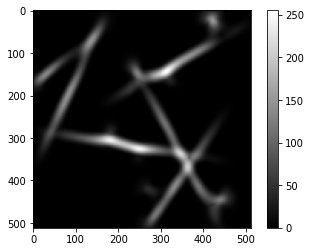

In [6]:
for imageIndex in range(0,len(imageAll)):

    plt.figure()
    plt.imshow(vesselnessAll[imageIndex], cmap='gray')
    plt.colorbar()
    plt.show()


In [29]:
# save images
hf = h5py.File('vesselsThin1.h5', 'w')
for i in range(0,len(vesselnessAll)):
    hf.create_dataset(str(i),data=vesselnessAll[i])
    
hf.close()

In [ ]:
import imageio
hf = h5py.File('vesselsThin1.h5', 'r')
for i in range(0,len(hf.keys())):
    image = hf.get(str(i))
    image = np.array(image)
    imageio.imwrite('../../data/thinVessels/'+ str(i) + '.png',image)

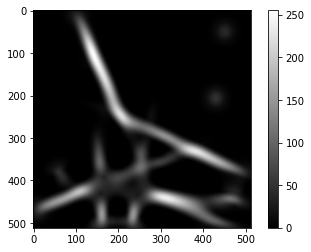

In [3]:
# load images
hf = h5py.File('vessels.h5', 'r')
hf.keys()
n1 = hf.get('3')
n1 = np.array(n1)
plt.figure()
plt.imshow(n1, cmap='gray')
plt.colorbar()
plt.show()

In [4]:
#blur images with gaussian blur
hfBlur = h5py.File('vesselsBlur.h5', 'w')
for image in hf.keys():
    vessel = np.array(hf.get(image))
    filtered = gaussian_filter(vessel, sigma=100)
    hfBlur.create_dataset(image,data=filtered)

hfBlur.close()

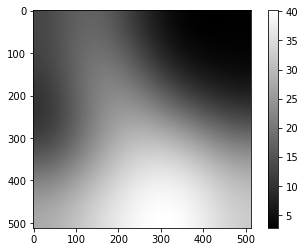

In [5]:
# load blurred images
hf = h5py.File('vesselsBlur.h5', 'r')
hf.keys()
n1 = hf.get('3')
n1 = np.array(n1)
plt.figure()
plt.imshow(n1, cmap='gray')
plt.colorbar()
plt.show()

# Virtual Ring Array

In [94]:
#===== load transducer positions =====#
array_dir           = '../utils/arrayInfo/virtualRingCup.mat'
arrayFile	        = sio.loadmat(array_dir)
transducerPos	    = arrayFile['transducerPos']

xSensorVirtualRing = np.transpose(transducerPos[:,0])   # positions in x
ySensorVirtualRing = np.transpose(transducerPos[:,1])   # positions in y
rSensorVirtualRing = np.sqrt(xSensorVirtualRing**2 + ySensorVirtualRing**2)

theta           = np.arctan2(ySensorVirtualRing,xSensorVirtualRing)
angleSensor     = theta + 2*math.pi*(np.multiply((xSensorVirtualRing>0),(ySensorVirtualRing<0)))

In [95]:
# modelMatrixVirtualRing     = calculateModelMatrix(speedOfSound, resolutionXY, reconDimsXY, timePoints, rSensorVirtualRing, angleSensor, nAngles)

# save_npz('../data/modelMatrixVirtualRing.npz', modelMatrixVirtualRing)

In [96]:
modelMatrixVirtualRing = load_npz('../data/modelMatrixVirtualRing.npz')

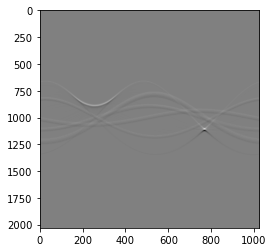

In [97]:
#===== forward model =====#
sigMatVec       = modelMatrixVirtualRing*imageFlat

sigMatVirtualRing          = np.transpose(sigMatVec.reshape(len(xSensorVirtualRing), -1))

#===== visualize signals =====#
plt.figure()
plt.imshow(sigMatVirtualRing, cmap='gray')
plt.show
plt.axes().set_aspect(0.5)



# Multisegment

In [98]:
#===== load transducer positions =====#
array_dir           = '../utils/arrayInfo/multisegmentCup.mat'
arrayFile	        = sio.loadmat(array_dir)
transducerPos	    = arrayFile['transducerPos']

xSensorMultisegment = np.transpose(transducerPos[:,0])   # positions in x
ySensorMultisegment = np.transpose(transducerPos[:,1])   # positions in y
rSensorMultisegment = np.sqrt(xSensorMultisegment**2 + ySensorMultisegment**2)

theta           = np.arctan2(ySensorMultisegment,xSensorMultisegment)
angleSensor     = theta + 2*math.pi*(np.multiply((xSensorMultisegment>0),(ySensorMultisegment<0)))

In [99]:
# modelMatrixMultisegment     = calculateModelMatrix(speedOfSound, resolutionXY, reconDimsXY, timePoints, rSensorMultisegment, angleSensor, nAngles)

# save_npz('../data/modelMatrixMultisegment.npz', modelMatrixMultisegment)

In [100]:
modelMatrixMultisegment = load_npz('../data/modelMatrixMultisegment.npz')

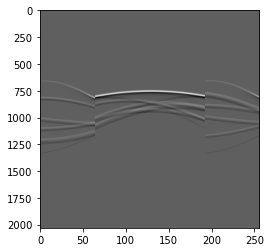

In [101]:
#===== forward model =====#
sigMatVec          = modelMatrixMultisegment*imageFlat

sigMatMultisegment = np.transpose(sigMatVec.reshape(len(xSensorMultisegment), -1))

#===== visualize signals =====#
plt.figure()
plt.imshow(sigMatMultisegment, cmap='gray')
plt.show
plt.axes().set_aspect(0.125)

In [102]:
# Expand dimensions for reconstruction

In [103]:
# expand dimensions
if sigMatVirtualRing.ndim != 3:
    sigMatVirtualRing = np.expand_dims(sigMatVirtualRing, axis=2)

if sigMatMultisegment.ndim != 3:
    sigMatMultisegment = np.expand_dims(sigMatMultisegment, axis=2)

# filter sigMat
sigMatVirtualRingF = sigMatFilter(sigMatVirtualRing, lowCutOff, highCutOff, fSampling, fOrder, 0.5)

sigMatMultisegmentF = sigMatFilter(sigMatMultisegment, lowCutOff, highCutOff, fSampling, fOrder, 0.5)

# normalize sigMat around 0
sigMatVirtualRingN         = sigMatNormalize(sigMatVirtualRingF)
sigMatMultisegmentN        = sigMatNormalize(sigMatMultisegmentF)

# MB

<function matplotlib.pyplot.show(*args, **kw)>

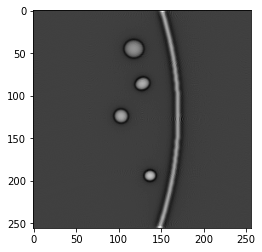

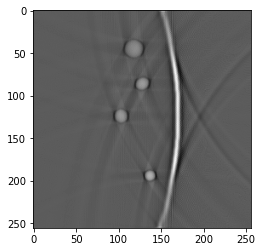

In [104]:
#===== reconstruct image =====#
regMatrix       = calculateRegularizationMatrix(resolutionXY, lambdaReg)

# crop sigMat
# sigMat          = cropMatrix(sigMat, xSensor, ySensor, reconDimsXY, fSampling, speedOfSound, delayInSamples, nSamples)

# reconstruction
imageReconVirtualRing = sigMatReconMB(sigMatVirtualRingN, modelMatrixVirtualRing, regMatrix, iterationNum, resolutionXY)

imageReconMultisegment = sigMatReconMB(sigMatMultisegmentN, modelMatrixMultisegment, regMatrix, iterationNum, resolutionXY)

#===== visualize image =====#
plt.figure()
plt.imshow(imageReconVirtualRing, cmap='gray')
plt.show

plt.figure()
plt.imshow(imageReconMultisegment, cmap='gray')
plt.show

# BP

<function matplotlib.pyplot.show(*args, **kw)>

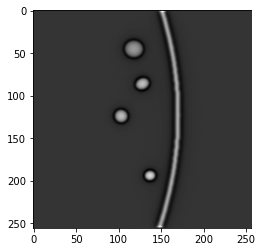

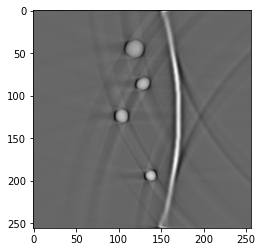

In [105]:
# smooth for gap between linear and concave parts (we can skip for now, doesnt change output a lot)
# sigMatS         = sigMatSmooth(sigMatN)

# reconstruction
imageReconVirtualRing = sigMatReconBP(sigMatVirtualRingN, resolutionXY, xSensorVirtualRing, ySensorVirtualRing, speedOfSound, timePoints, fSampling, reconDimsXY)

imageReconMultisegment      = sigMatReconBP(sigMatMultisegmentN, resolutionXY, xSensorMultisegment, ySensorMultisegment, speedOfSound, timePoints, fSampling, reconDimsXY)

imageReconVirtualRing      = np.fliplr(np.rot90(imageReconVirtualRing,3))
imageReconMultisegment     = np.fliplr(np.rot90(imageReconMultisegment,3))

######### visualize image ##########
plt.figure()
plt.imshow(imageReconVirtualRing, cmap='gray')
plt.show

plt.figure()
plt.imshow(imageReconMultisegment, cmap='gray')
plt.show